In [2]:
import numpy as np
from skimage import io, util, measure, transform
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd
from imageUtils import normalize_image_intensity_signed

from os import path
import stackview
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator

from measurements import get_mesh_from_bm_image, export_mesh, get_tissue_curvature_over_grid,get_tissue_curvature_sparse, \
    get_bm_image

from trimesh import Trimesh
import pyvista as pv
pv.set_jupyter_backend('trame')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
calculate_height_image = False
calculate_mesh = False
calculate_curvature = False
dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R2/Cropped'

dz = 0.5
dx = 0.3

collagen = io.imread(path.join(dirname,'B.tif'))
k10 = io.imread(path.join(dirname,'G.tif'))
mem = io.imread(path.join(dirname,'R.tif'))
if calculate_height_image:
    heightmap, height_image = get_bm_image(collagen,[4,20,20],+1)
    io.imsave(path.join(dirname,'heightmap.tif'),heightmap)
    io.imsave(path.join(dirname,'height_image.tif'),height_image)
else:
    heightmap = io.imread(path.join(dirname,'heightmap.tif'))
    height_image = io.imread(path.join(dirname,'height_image.tif'))

if calculate_mesh:
    mesh = get_mesh_from_bm_image(height_image,spacing=[dz,dx,dx],decimation_factor=60)
    export_mesh(mesh,path.join(dirname,'bm_mesh.npz'),
               values = get_tissue_curvature_sparse(mesh)[0])
else:
    mesh = np.load(path.join(dirname,'bm_mesh.npz'))
    mesh = Trimesh(mesh['vertices'],mesh['faces'])

if calculate_curvature:
    curvature,gaussian_curvature = get_tissue_curvature_over_grid(mesh,k10.shape,spacing=[dz,dx,dx])
    curvature = curvature.T
    gaussian_curvature = gaussian_curvature.T
    np.savez(path.join(dirname,'mean_curvature.npz'),mean_curvature=curvature)
    np.savez(path.join(dirname,'gaussian_curvature.npz'),gaussian_curvature=gaussian_curvature)
else:
    curvature = np.load(path.join(dirname,'mean_curvature.npz'))['mean_curvature']
    gaussian_curvautre = np.load(path.join(dirname,'gaussian_curvature.npz'))['gaussian_curvature']

mask = io.imread(path.join(dirname,'mask.tif')) > 1

stackview.orthogonal(k10, zoom_factor=0.5,continuous_update=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R2/Cropped/mask.tif'

In [46]:
pl = pv.Plotter()
pl.add_mesh(mesh)
pl.show()

Widget(value='<iframe src="http://localhost:61299/index.html?ui=P_0x329ffbd70_2&reconnect=auto" class="pyvista…

In [52]:
# Construct slicer
Nslice = 20
k10_resliced = np.zeros((Nslice,*heightmap.shape),dtype=np.uint16)

mem_resliced = np.zeros((Nslice,*heightmap.shape),dtype=np.uint16)

for i in range(Nslice):
    _heightmap = np.clip(heightmap-10+i,a_min=0,a_max=k10.shape[0]-1)
    k10_resliced[i,:,:] = np.take_along_axis(k10, _heightmap[np.newaxis, :, :],axis=0)
    mem_resliced[i,:,:] = np.take_along_axis(mem, _heightmap[np.newaxis, :, :],axis=0)

io.imsave(path.join(dirname,'k10_resliced.tif'),k10_resliced)
io.imsave(path.join(dirname,'mem_resliced.tif'),mem_resliced)
# io.imsave(path.join(dirname,'mem2d.tif'),mem_resliced[0,...])
stackview.slice(k10_resliced,zoom_factor=0.5)

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R2/Cropped/k10_resliced.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R2/Cropped/mem_resliced.tif is a low contrast image
  return func(*args, **kwargs)


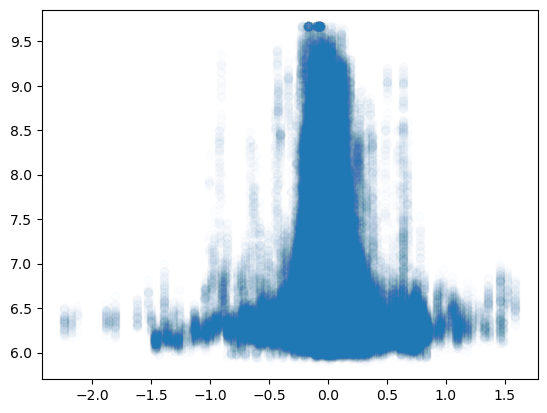

In [23]:
plt.scatter(curvature,np.log(k10_resliced[0,...]),alpha=0.01)
# plot_bin_means(curvature,np.log(k10_max),bin_edges=20,minimum_n=50,color='r')
# df.loc[1659]

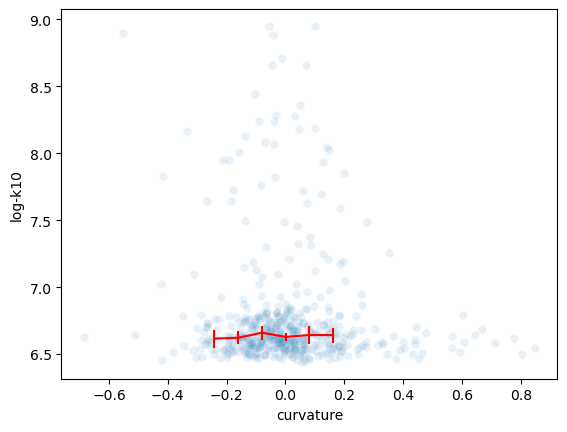

In [54]:

import pandas as pd
from skimage import measure, filters
import seaborn as sb
from basicUtils import plot_bin_means

# masks = io.imread(path.join(dirname,'membrane_reslice_z3_cp_masks.tif'))
masks = np.load(path.join(dirname,'mem_basal_seg.npy'),allow_pickle=True).item()['masks'] 

k10_max = (k10_resliced).max(axis=0).astype(float)
# k10_max = k10_resliced[0,...]
df = pd.DataFrame(measure.regionprops_table(masks,intensity_image=k10_max,properties=['label','intensity_mean']))
df = df.set_index('label').rename(columns={'intensity_mean':'k10'})
df_ = pd.DataFrame(measure.regionprops_table(masks,intensity_image=curvature,properties=['label','intensity_mean']))
df_ = df_.set_index('label').rename(columns={'intensity_mean':'curvature'})
# df_ = pd.DataFrame(measure.regionprops_table(masks,intensity_image=gaussian_curvautre,properties=['label','intensity_mean']))
# df_ = df_.set_index('label').rename(columns={'intensity_mean':'gaussian_curvature'})

df = pd.merge(df,df_,left_index=True,right_index=True)
df['log-k10'] = np.log(df['k10'])
sb.scatterplot(df,y='log-k10',x='curvature',alpha=0.1)
plot_bin_means(df['curvature'],df['log-k10'],bin_edges=20,minimum_n=20,color='r',mean='median')

df.to_csv(path.join(dirname,'data_frame.csv'))

In [26]:
k10_blur = gaussian_filter((k10_resliced).max(axis=0).astype(float),sigma=[10,10])
stackview.switch({'k10':k10_max*mask,
                    'mean':curvature},
                colormap=['pure_green','pure_magenta'],
                toggleable=True)

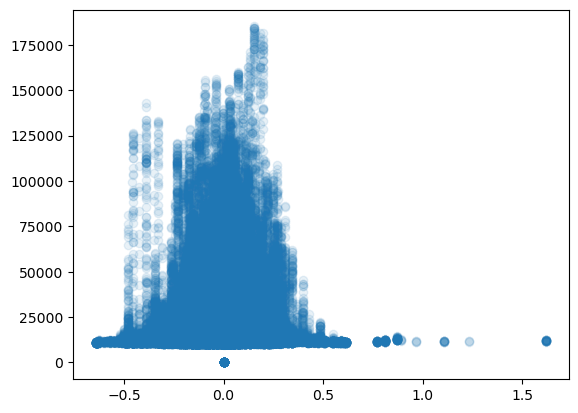

In [71]:
plt.scatter((curvature*mask).flatten(),(k10_resliced.sum(axis=0)*mask).flatten(),alpha=0.1)

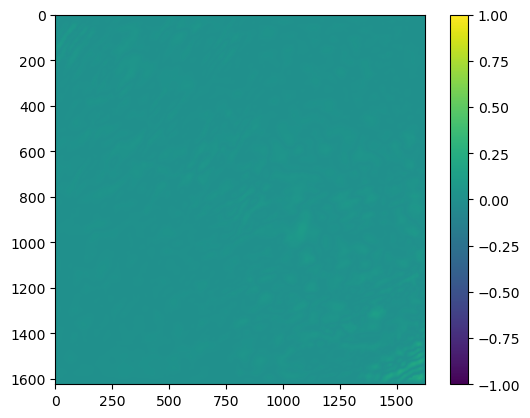

In [65]:
from mathUtils import normxcorr2

C = normxcorr2(k10_resliced.max(axis=0)[100:-100,100:-100],curvature[100:-100,100:-100])
plt.imshow(C,cmap='viridis',vmin=-1,vmax=1)
plt.colorbar()

In [134]:
C.max()

np.float64(0.08813692556684703)

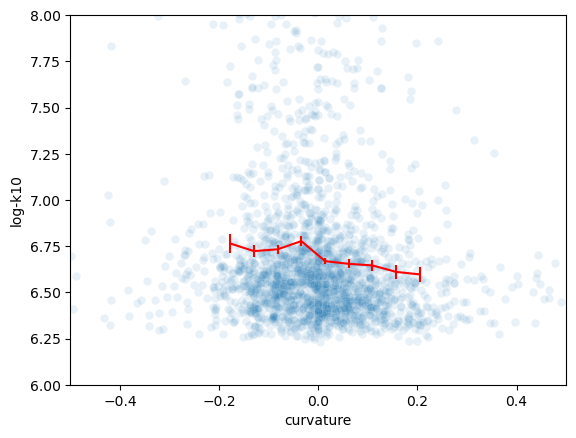

In [82]:
df1 = pd.read_csv('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R1/Uncropped/data_frame.csv',index_col='label')
df1['Region'] = 'R1'
df2 = pd.read_csv('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/K10-R2/Cropped/data_frame.csv',index_col='label')
df2['Region'] = 'R2'
df = pd.concat((df1,df2),ignore_index=True)
sb.scatterplot(df,x='curvature',y='log-k10',alpha=0.1)
plot_bin_means(df['curvature'],df['log-k10'],bin_edges=40,minimum_n=50,mean='mean',color='r')
plt.xlim([-.5,.5])
plt.ylim([6,8])

plt.gcf().savefig(path.join('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/Shared/K10 paw/Figures/k10_v_curvature.svg'))

In [85]:
from scipy import stats

stats.pearsonr(df['curvature'],df['log-k10'])

PearsonRResult(statistic=np.float64(-0.09783836887916617), pvalue=np.float64(2.9066975143682647e-06))